In [35]:
import pandas as pd
import numpy as np

In [36]:
xls_CDNB = pd.ExcelFile(r'/Users/hongnhungvu/Desktop/Thesis_Data/CDNB_cleaned.xlsx')
df_NB = pd.read_excel(xls_CDNB)
xls_NLQ = pd.ExcelFile(r'/Users/hongnhungvu/Desktop/Thesis_Data/NLQ_cleaned.xlsx')
df_NLQ = pd.read_excel(xls_NLQ)
df_IT = df_NB.append(df_NLQ,ignore_index=True,sort=False) 

In [37]:
df_IT = df_IT.drop(df_IT[(df_IT.RegisterBuyVolume.isnull())&(df_IT.BuyVolume == 0)].index)
df_IT = df_IT.drop(df_IT[(df_IT.RegisterSellVolume.isnull())&(df_IT.SellVolume == 0)].index)

In [38]:
xls_1220 = pd.ExcelFile('/Users/hongnhungvu/Desktop/Thesis_Data/Data_IT/Data_Trading_2012_2020.xlsx')
xls_11 = pd.ExcelFile('/Users/hongnhungvu/Desktop/Thesis_Data/Data_IT/Data_Trading_2011.xlsx')
xls_21 = pd.ExcelFile('/Users/hongnhungvu/Desktop/Thesis_Data/Data_IT/Data_Trading_2021.xlsx')

df1_1220 = pd.read_excel(xls_1220, '1')
df2_1220 = pd.read_excel(xls_1220, '2')
df3_1220 = pd.read_excel(xls_1220, '3')
df4_11 = pd.read_excel(xls_11)
df5_21 = pd.read_excel(xls_21)

#Merge all into df_1121
df_1121 = df1_1220.append([df2_1220,df3_1220,df4_11,df5_21],ignore_index=True,sort=False)
df_1121_dup = df_1121.copy()
df_1121_dup.rename(columns={"TradingDate":"RegisterDate"}, inplace=True)

#Calculate daily ret of securities
df_1121_dup['Pi_ret'] = df_1121_dup.groupby('StockCode')['CloseAdj'].pct_change(-1)

In [39]:
#Map 'Exchange' & 'KLCPGD' values using cols
cols =['StockCode','RegisterDate']
df_IT['Exchange'] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols)['Exchange'])
df_IT['KLCPLH'] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols)['KLCPLH'])

#Calculate date difference
from datetime import datetime
T0 = [d.date() for d in df_IT['RegisterDate']]
T1 = [d.date() for d in df_IT['DateStartExpected']]
T2 = [d.date() for d in df_IT['DateEndExpected']]
df_IT['Diff_days_T0_T1'] = np.busday_count(T0, T1)
df_IT['Diff_days_T1_T2'] = np.busday_count(T1, T2)

#Recalculate percentage values
df_IT['RegisterVolumeBeforePercent'] = df_IT['RegisterVolumeBefore']/df_IT['KLCPLH']
df_IT['RegisterVolumeAfterPercent'] = df_IT['RegisterVolumeAfter']/df_IT['KLCPLH']
df_IT['VolumeBeforePercent'] = df_IT['VolumeBefore']/df_IT['KLCPLH']
df_IT['VolumeAfterPercent'] = df_IT['VolumeAfter']/df_IT['KLCPLH']

#Cleaning data: drop all percentage values>1
df_IT = df_IT[(df_IT['RegisterVolumeBeforePercent'] < 1) &
               (df_IT['RegisterVolumeAfterPercent'] < 1) &
               (df_IT['VolumeBeforePercent'] < 1) & (df_IT['VolumeAfterPercent']<1)]

In [40]:
df_IT = df_IT.drop(df_IT[df_IT.Diff_days_T1_T2 >= 46].index)

In [41]:
#Match Securities Ret
for x in range(-250,0):
    df_IT['Ri_T1_' + str(x)] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['Pi_ret'].shift(x))

df_IT['Ri_T1_0'] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols)['Pi_ret'])

for x in range(1,36):
    df_IT['Ri_T1_' + str(x)] = df_IT.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['Pi_ret'].shift(x))

In [42]:
#Benchmark trading data
xls_index = pd.ExcelFile(r'/Users/hongnhungvu/Desktop/Thesis_Data/Data_IT/Data_Index_2011_2021.xlsx')
df_index = pd.read_excel(xls_index)
df_index.rename(columns={"TradingDate":"RegisterDate","IndexCode":"Exchange"}, inplace=True)
df_index['Exchange'] = df_index['Exchange'].replace(['VNINDEX','HNXINDEX','UPCOMINDEX'],['VNI','HNX','UPCOM'])

df_HNX = df_index[df_index['Exchange']=='HNX'].copy()

#Calculate daily ret of benchmarks
df_HNX['Rm_ret'] = df_HNX['CloseIndex'].pct_change(-1)

In [43]:
#Match Benchmark Ret HNX
df_IT_HNX = df_IT[df_IT['Exchange']=='HNX'].copy()

for x in range(-250,0):
    df_IT_HNX['Rm_T1_' + str(x)] = df_IT_HNX.set_index('RegisterDate').index.map(df_HNX.set_index('RegisterDate')['Rm_ret'].shift(x))

df_IT_HNX['Rm_T1_0'] = df_IT_HNX.set_index('RegisterDate').index.map(df_HNX.set_index('RegisterDate')['Rm_ret'])

for x in range(1,36):
    df_IT_HNX['Rm_T1_' + str(x)] = df_IT_HNX.set_index('RegisterDate').index.map(df_HNX.set_index('RegisterDate')['Rm_ret'].shift(x))

In [44]:
import statsmodels.api as sm

#Regress Ri on Rm

def regress(data):
    result_all=[]
    for i in range(len(data)):
        Y = list(data.iloc[i][34:255])
        X = list(data.iloc[i][320:541])
        X = sm.add_constant(X)
        result = sm.OLS(Y,X).fit()
        result_all.append(result.params)
    return result_all  

#Why slice [34:255] and [320:541]
#df_IT_HNX.columns.get_indexer(['Ri_T1_-250', 'Ri_T1_-30','Rm_T1_-250', 'Rm_T1_-30'])
#array([ 34, 254, 320, 540])

#Run for HNX
res_HNX = regress(df_IT_HNX)

In [45]:
#Insert alphas & betas into df_IT_HNX
df_IT_HNX['alpha'] = np.array(res_HNX)[:,0]
df_IT_HNX['beta'] = np.array(res_HNX)[:,1]

In [46]:
df_HNX_buy = pd.DataFrame(df_IT_HNX[(df_IT_HNX['RegisterSellVolume'].isnull())])
df_HNX_sell = pd.DataFrame(df_IT_HNX[(df_IT_HNX['RegisterBuyVolume'].isnull())])

In [47]:
def cal_ar_nosum(data,a,b,c,d):
    car_all_nosum=[]
    for i in range(len(data)):
        r_i = list(data.iloc[i][a:b])
        r_m = list(data.iloc[i][c:d])
        car = [s - data.iloc[i]['alpha'] - m*data.iloc[i]['beta'] for s,m in zip(r_i,r_m)]
        car_all_nosum.append(car)
    return car_all_nosum

#Why slice [254:320] and [540:606]
#df_HNX_buy.columns.get_indexer(['Ri_T1_-30', 'Ri_T1_35','Rm_T1_-30', 'Rm_T1_35'])
#array(([254, 319, 540, 605])

ar_buy_HNX = cal_ar_nosum(df_HNX_buy,254,320,540,606)

In [48]:
df_ar_buy_HNX = pd.DataFrame(ar_buy_HNX, index=[df_HNX_buy.index], columns= [i for i in range(-30,36)]) 
df_ar_buy_HNX = df_ar_buy_HNX.cumsum(axis=1)

df_ar_buy_HNX['Period_length_T0_T1']= df_HNX_buy['Diff_days_T0_T1'].values
df_ar_buy_HNX_123 = df_ar_buy_HNX[(df_ar_buy_HNX['Period_length_T0_T1']<=3)]

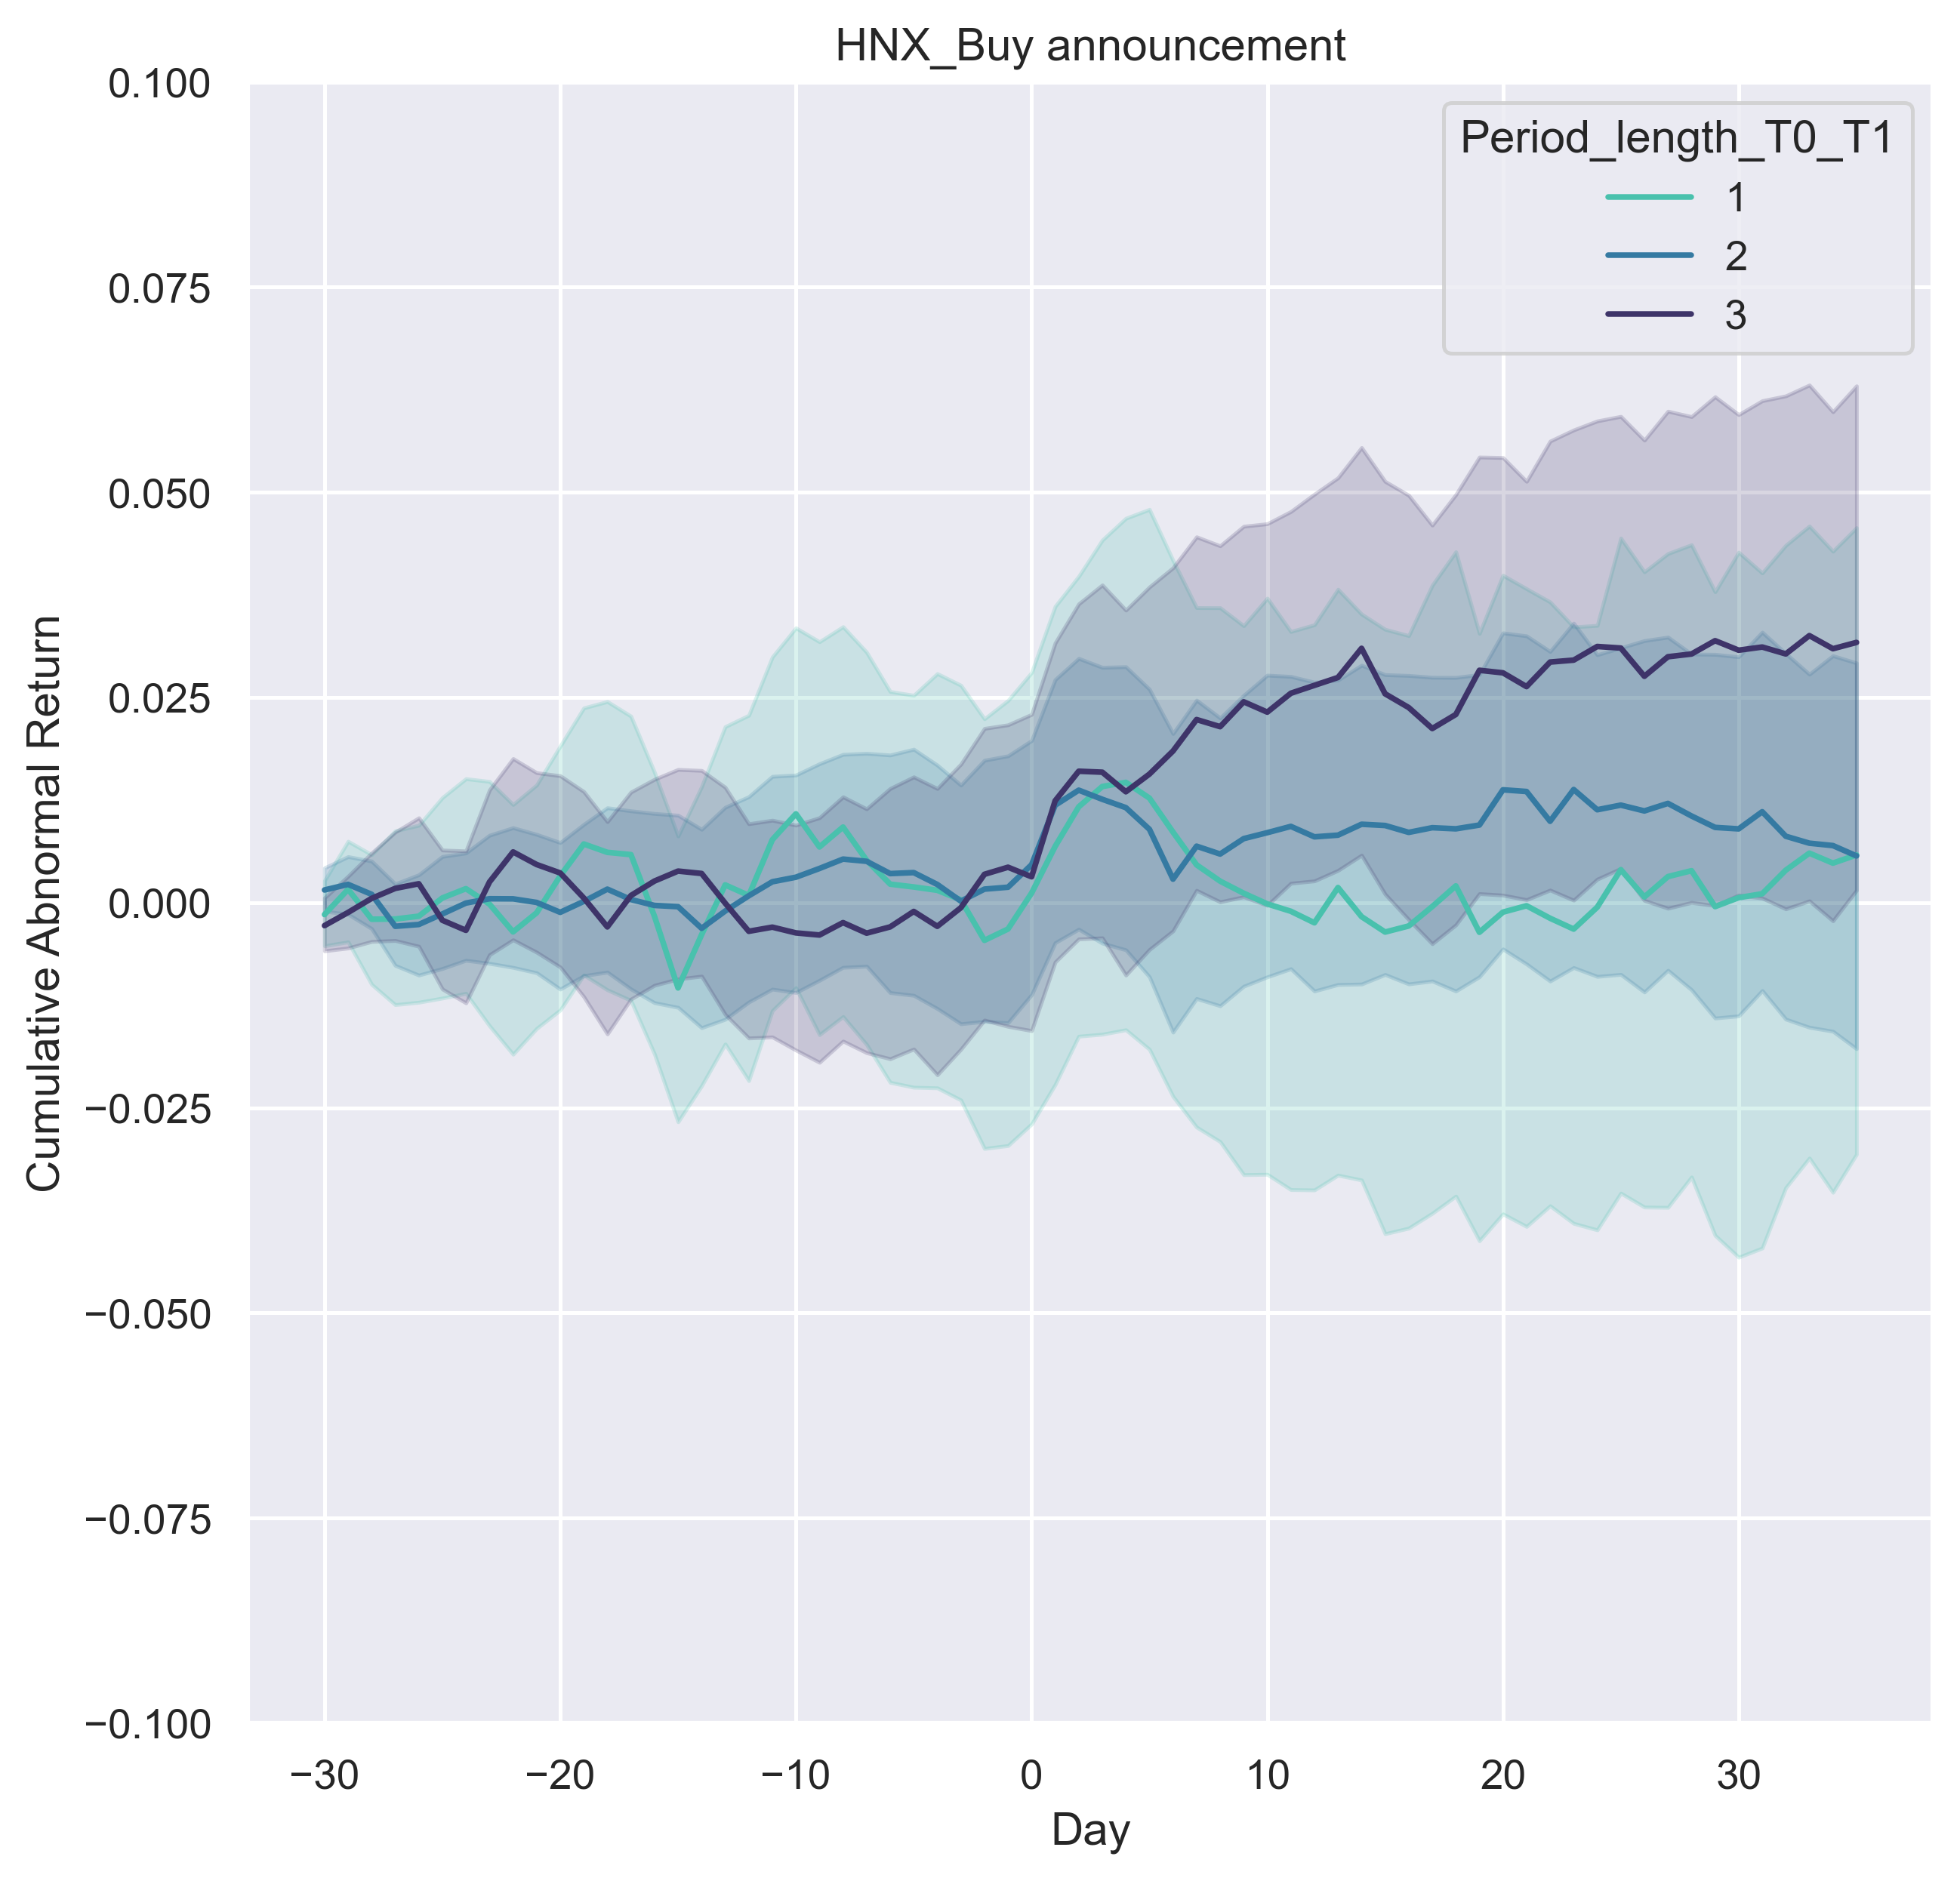

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize": (8, 8)})
palette = sns.color_palette("mako_r", 3)
plt.rcParams['figure.dpi'] = 360


df_ar_buy_HNX_123corrected = pd.DataFrame(df_ar_buy_HNX_123.set_index('Period_length_T0_T1').stack())
df_ar_buy_HNX_123corrected.index.set_names('Day', level=len(df_ar_buy_HNX_123corrected.index.names)-1, inplace=True)
df_ar_buy_HNX_123corrected.columns = ['Cumulative Abnormal Return']

CAR_buy_HNX = sns.lineplot(data=df_ar_buy_HNX_123corrected, x="Day", y="Cumulative Abnormal Return",hue="Period_length_T0_T1",ci=90,palette=palette)
CAR_buy_HNX.set(title='HNX_Buy announcement')
CAR_buy_HNX.set(ylim=(-0.1, 0.1))


plt.savefig("CAR_buy_HNX.png")
#CMAR_buy_HNX.figure.savefig("CMAR_buy_HNX.png")

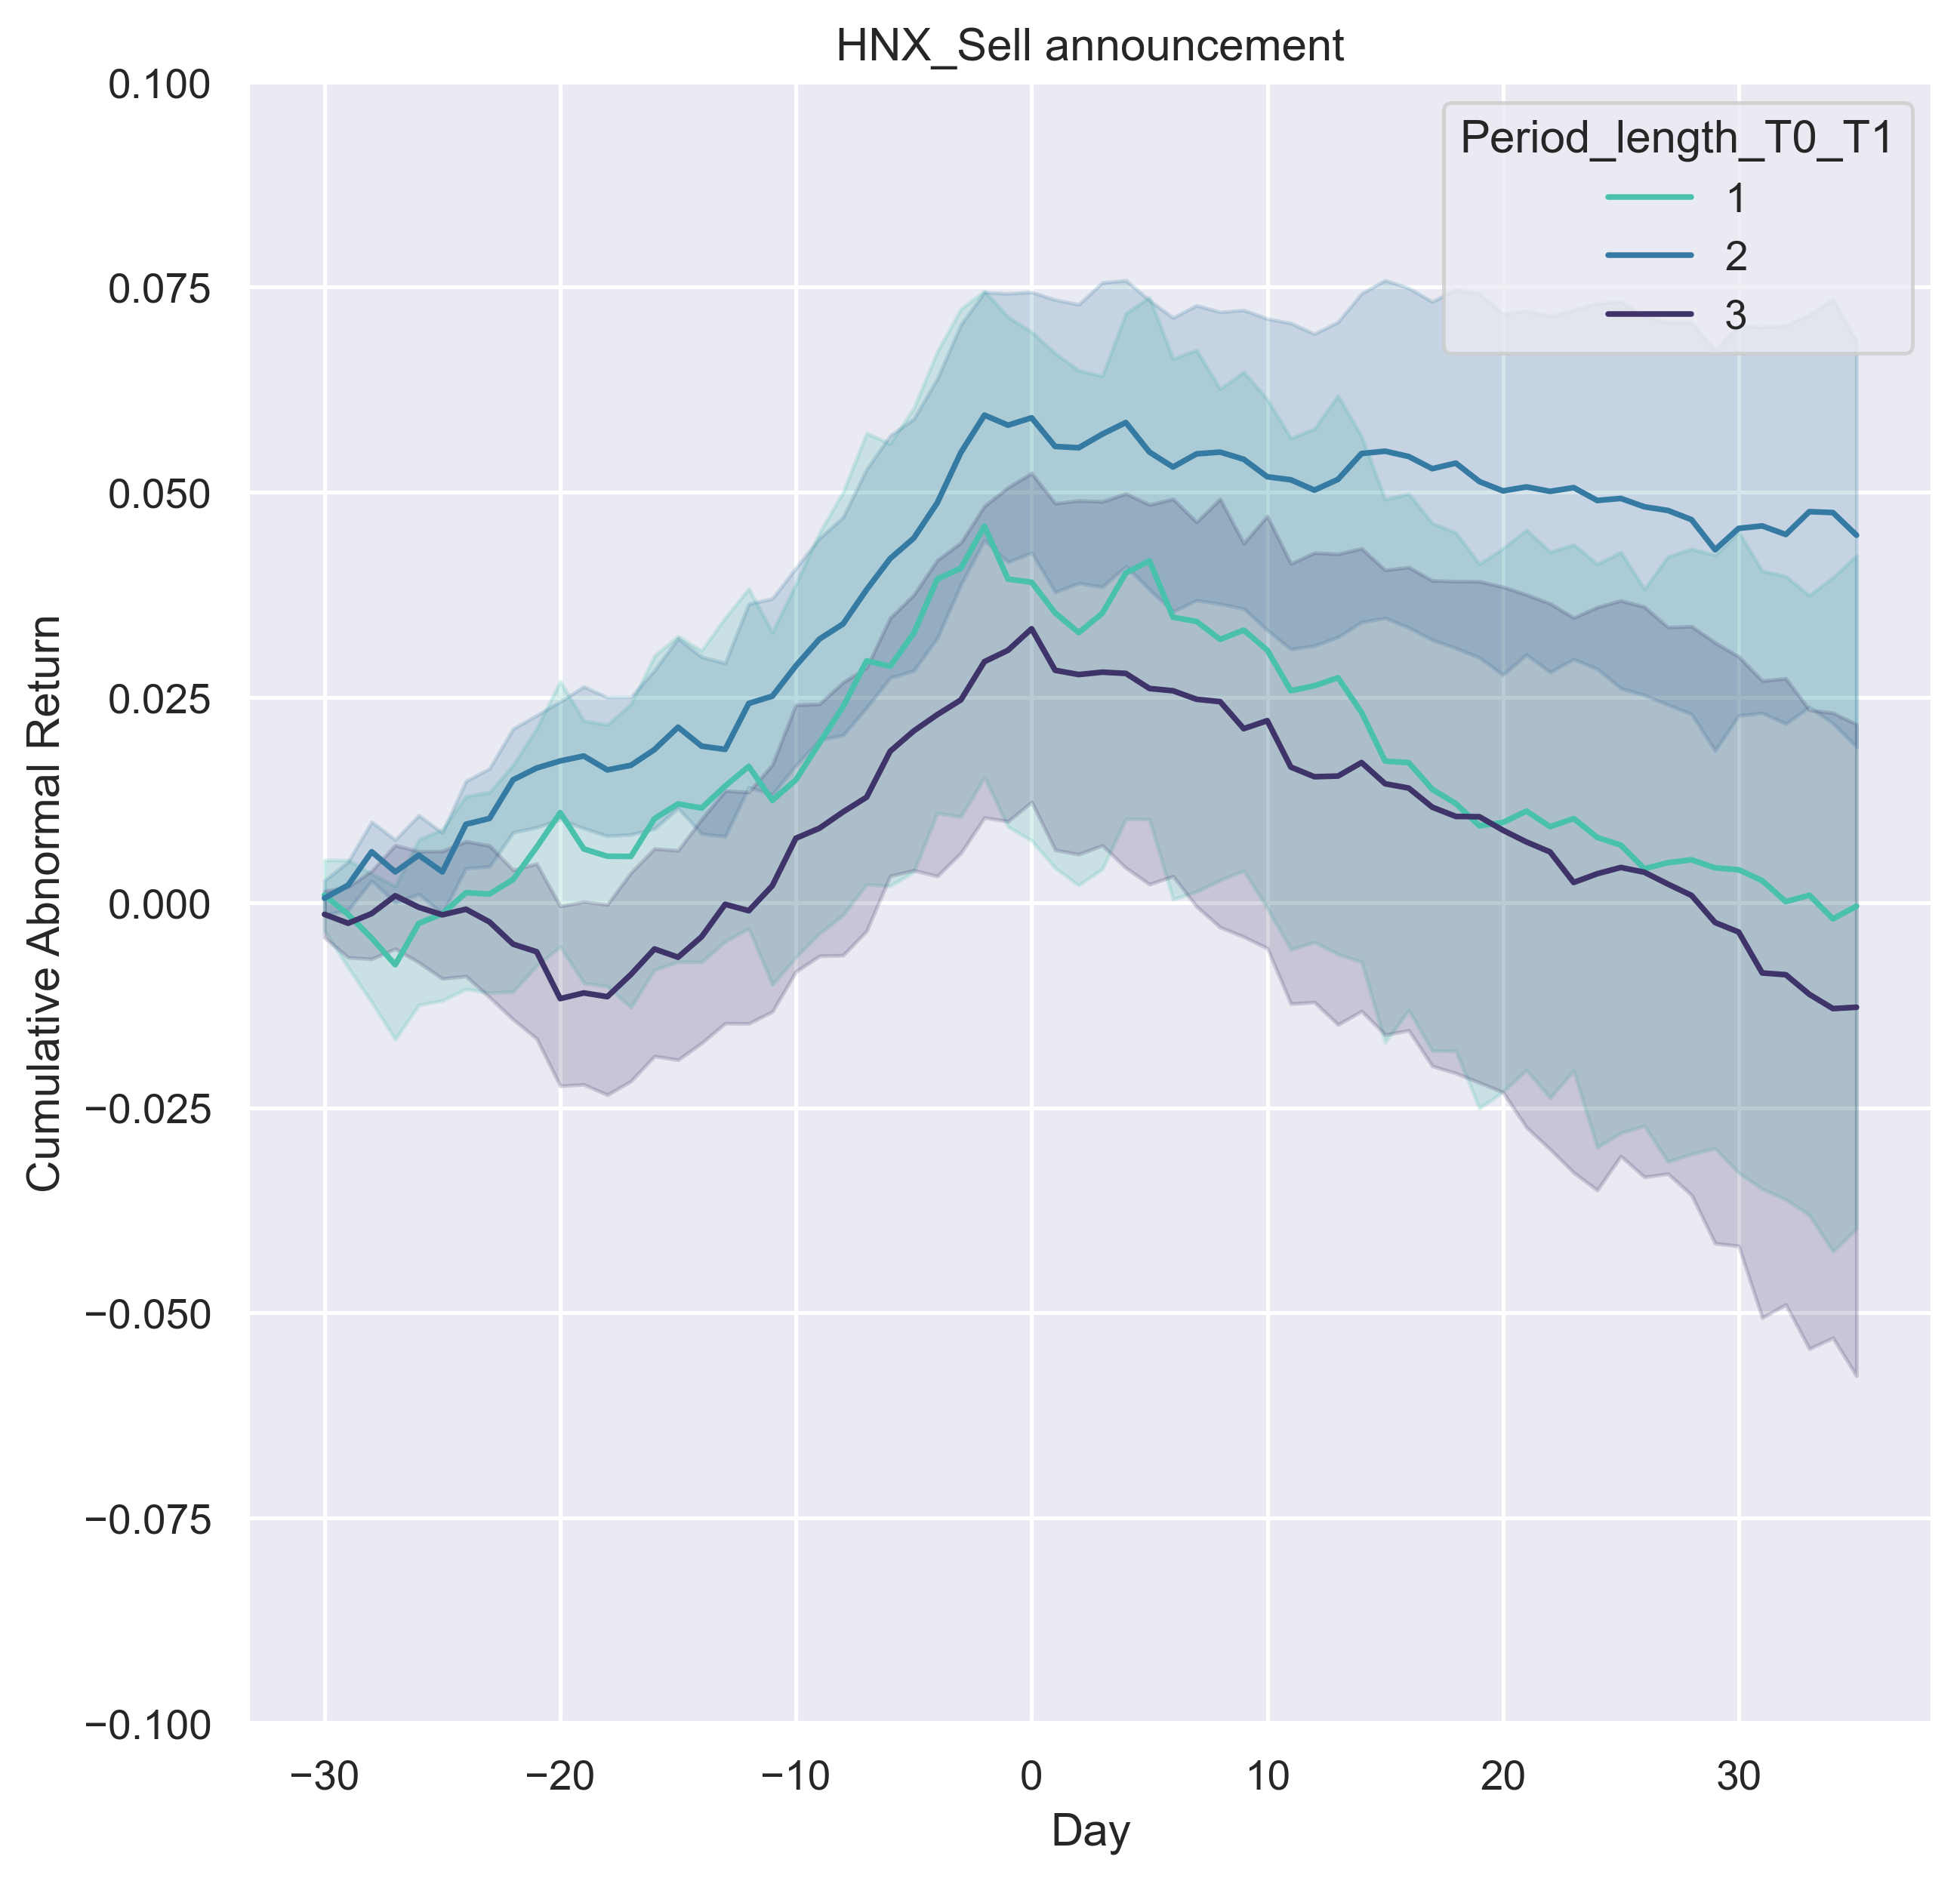

In [50]:
ar_sell_HNX = cal_ar_nosum(df_HNX_sell,254,320,540,606)

df_ar_sell_HNX = pd.DataFrame(ar_sell_HNX, index=[df_HNX_sell.index], columns= [i for i in range(-30,36)]) 
df_ar_sell_HNX = df_ar_sell_HNX.cumsum(axis=1)

df_ar_sell_HNX['Period_length_T0_T1']= df_HNX_sell['Diff_days_T0_T1'].values
df_ar_sell_HNX_123 = df_ar_sell_HNX[(df_ar_sell_HNX['Period_length_T0_T1']<=3)]

df_ar_sell_HNX_123corrected = pd.DataFrame(df_ar_sell_HNX_123.set_index('Period_length_T0_T1').stack())
df_ar_sell_HNX_123corrected.index.set_names('Day', level=len(df_ar_sell_HNX_123corrected.index.names)-1, inplace=True)
df_ar_sell_HNX_123corrected.columns = ['Cumulative Abnormal Return']

CAR_sell_HNX = sns.lineplot(data=df_ar_sell_HNX_123corrected, x="Day", y="Cumulative Abnormal Return",hue="Period_length_T0_T1",ci=90,palette=palette)
CAR_sell_HNX.set(title='HNX_Sell announcement')
CAR_sell_HNX.set(ylim=(-0.1, 0.1))


plt.savefig("CAR_sell_HNX.png")
#CMAR_sell_HNX.figure.savefig("CMAR_sell_HNX.png")

In [31]:
#Plot the trend of Trading volume in (-30,+35)
cols =['StockCode','RegisterDate']

#Match Securities Trading Vol
#of buy news 
for x in range(-30,0):
    df_HNX_buy['Vol_T1_' + str(x)] = df_HNX_buy.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['TotalVol'].shift(x))

df_HNX_buy['Vol_T1_0'] = df_HNX_buy.set_index(cols).index.map(df_1121_dup.set_index(cols)['TotalVol'])

for x in range(1,36):
    df_HNX_buy['Vol_T1_' + str(x)] = df_HNX_buy.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['TotalVol'].shift(x))
    
#of sell news
for x in range(-30,0):
    df_HNX_sell['Vol_T1_' + str(x)] = df_HNX_sell.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['TotalVol'].shift(x))

df_HNX_sell['Vol_T1_0'] = df_HNX_sell.set_index(cols).index.map(df_1121_dup.set_index(cols)['TotalVol'])

for x in range(1,36):
    df_HNX_sell['Vol_T1_' + str(x)] = df_HNX_sell.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['TotalVol'].shift(x))

In [32]:
#Match Securities Outstanding Shares
#of buy news 
for x in range(-30,0):
    df_HNX_buy['TOS_T1_' + str(x)] = df_HNX_buy.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['KLCPLH'].shift(x))

df_HNX_buy['TOS_T1_0'] = df_HNX_buy.set_index(cols).index.map(df_1121_dup.set_index(cols)['KLCPLH'])

for x in range(1,36):
    df_HNX_buy['TOS_T1_' + str(x)] = df_HNX_buy.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['KLCPLH'].shift(x))
    
#of sell news
for x in range(-30,0):
    df_HNX_sell['TOS_T1_' + str(x)] = df_HNX_sell.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['KLCPLH'].shift(x))

df_HNX_sell['TOS_T1_'] = df_HNX_sell.set_index(cols).index.map(df_1121_dup.set_index(cols)['KLCPLH'])

for x in range(1,36):
    df_HNX_sell['TOS_T1_' + str(x)] = df_HNX_sell.set_index(cols).index.map(df_1121_dup.set_index(cols).groupby('StockCode')['KLCPLH'].shift(x))

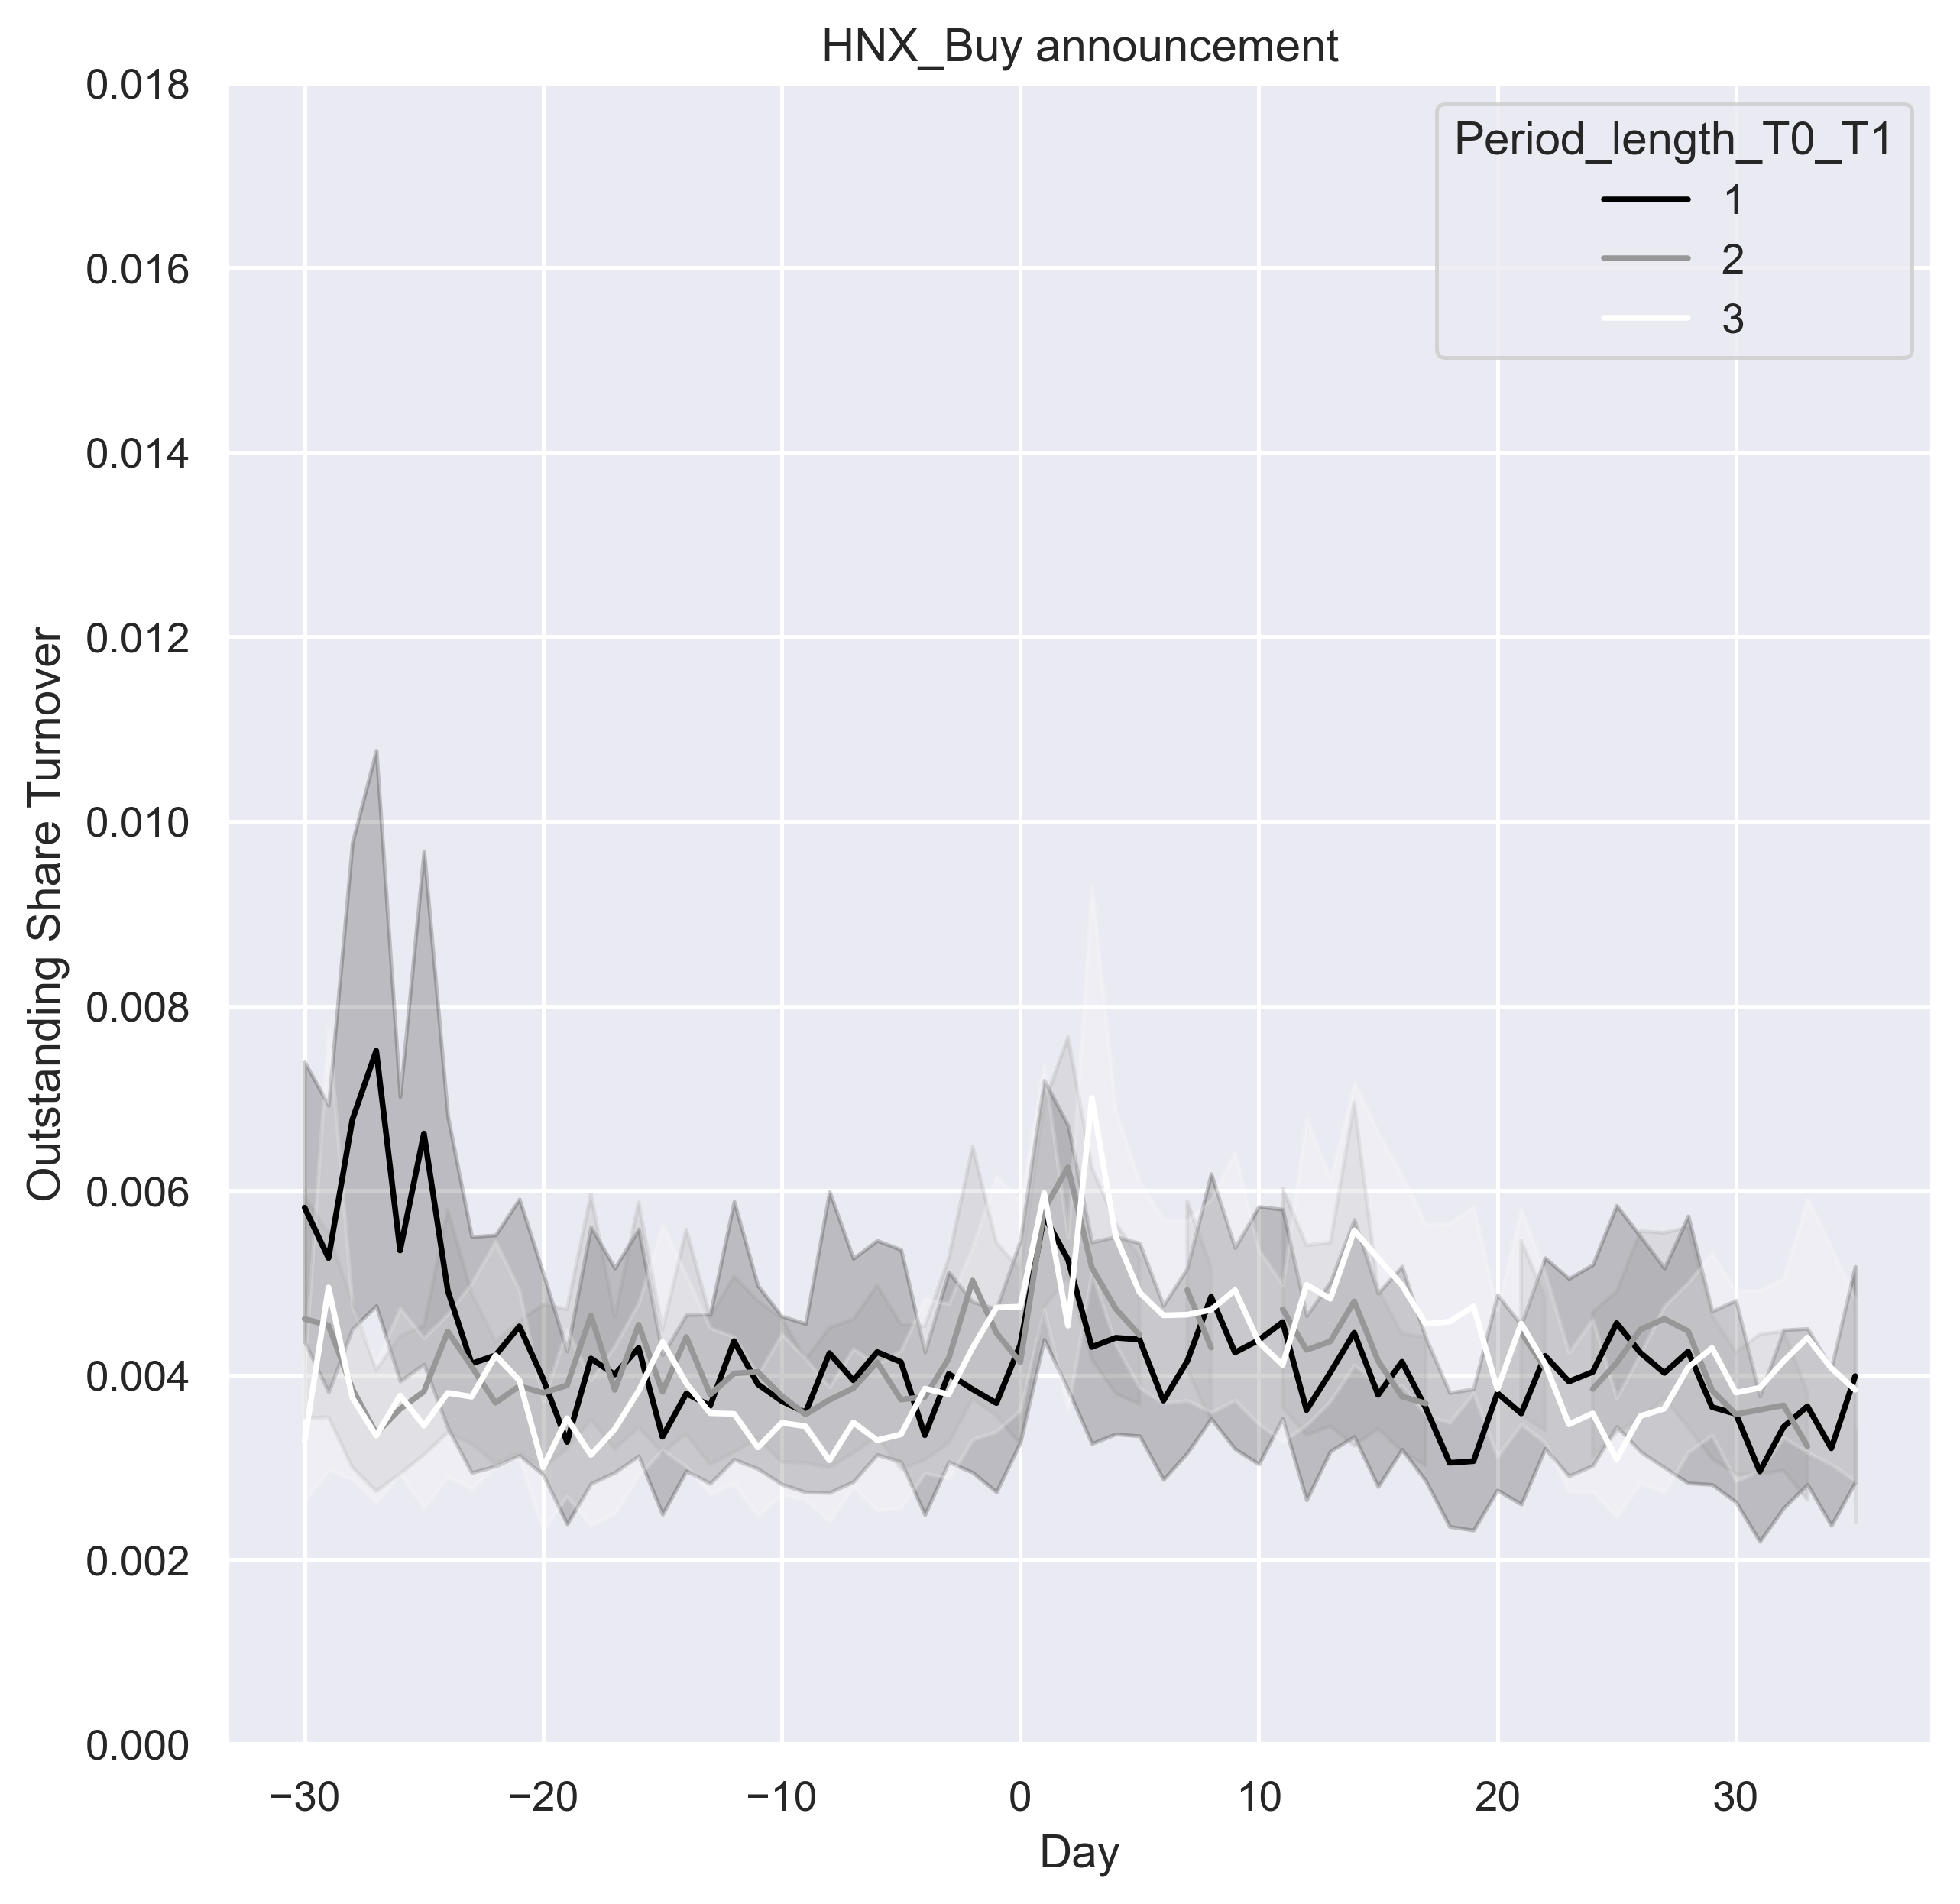

In [33]:
df_buy_vol_HNX = df_HNX_buy.iloc[:,608:674].copy()
df_buy_tos_HNX = df_HNX_buy.iloc[:,674:740].copy()
df_buy_turnover_HNX = df_buy_vol_HNX.div(df_buy_tos_HNX.values)
df_buy_turnover_HNX['Period_length_T0_T1'] = df_HNX_buy['Diff_days_T0_T1'].values
df_buy_turnover_HNX.columns = [i for i in range(-30,37)]
df_buy_turnover_HNX.rename({36: 'Period_length_T0_T1'}, axis=1, inplace=True)

df_buy_turnover_HNX_new = df_buy_turnover_HNX[(df_buy_turnover_HNX['Period_length_T0_T1']<=3)]
df_buy_turnover_HNX_corrected = pd.DataFrame(df_buy_turnover_HNX_new.set_index('Period_length_T0_T1').stack())
df_buy_turnover_HNX_corrected.index.set_names('Day', level=len(df_buy_turnover_HNX_corrected.index.names)-1, inplace=True)
df_buy_turnover_HNX_corrected.columns = ['Outstanding Share Turnover']

OST_buy = sns.lineplot(data=df_buy_turnover_HNX_corrected, x="Day", y="Outstanding Share Turnover",hue="Period_length_T0_T1",ci=90,palette="Greys_r")
OST_buy.set(title='HNX_Buy announcement')
OST_buy.set(ylim=(0, 0.018))

plt.savefig("OST_buy_HNX.png")

#OST_buy.figure.savefig("OST_buy_HNX.png")

#df_HNX_buy.columns.get_indexer(['Vol_T1_-30', 'Vol_T1_35','TOS_T1_-30', 'TOS_T1_35'])
#array([608, 673, 674, 739])

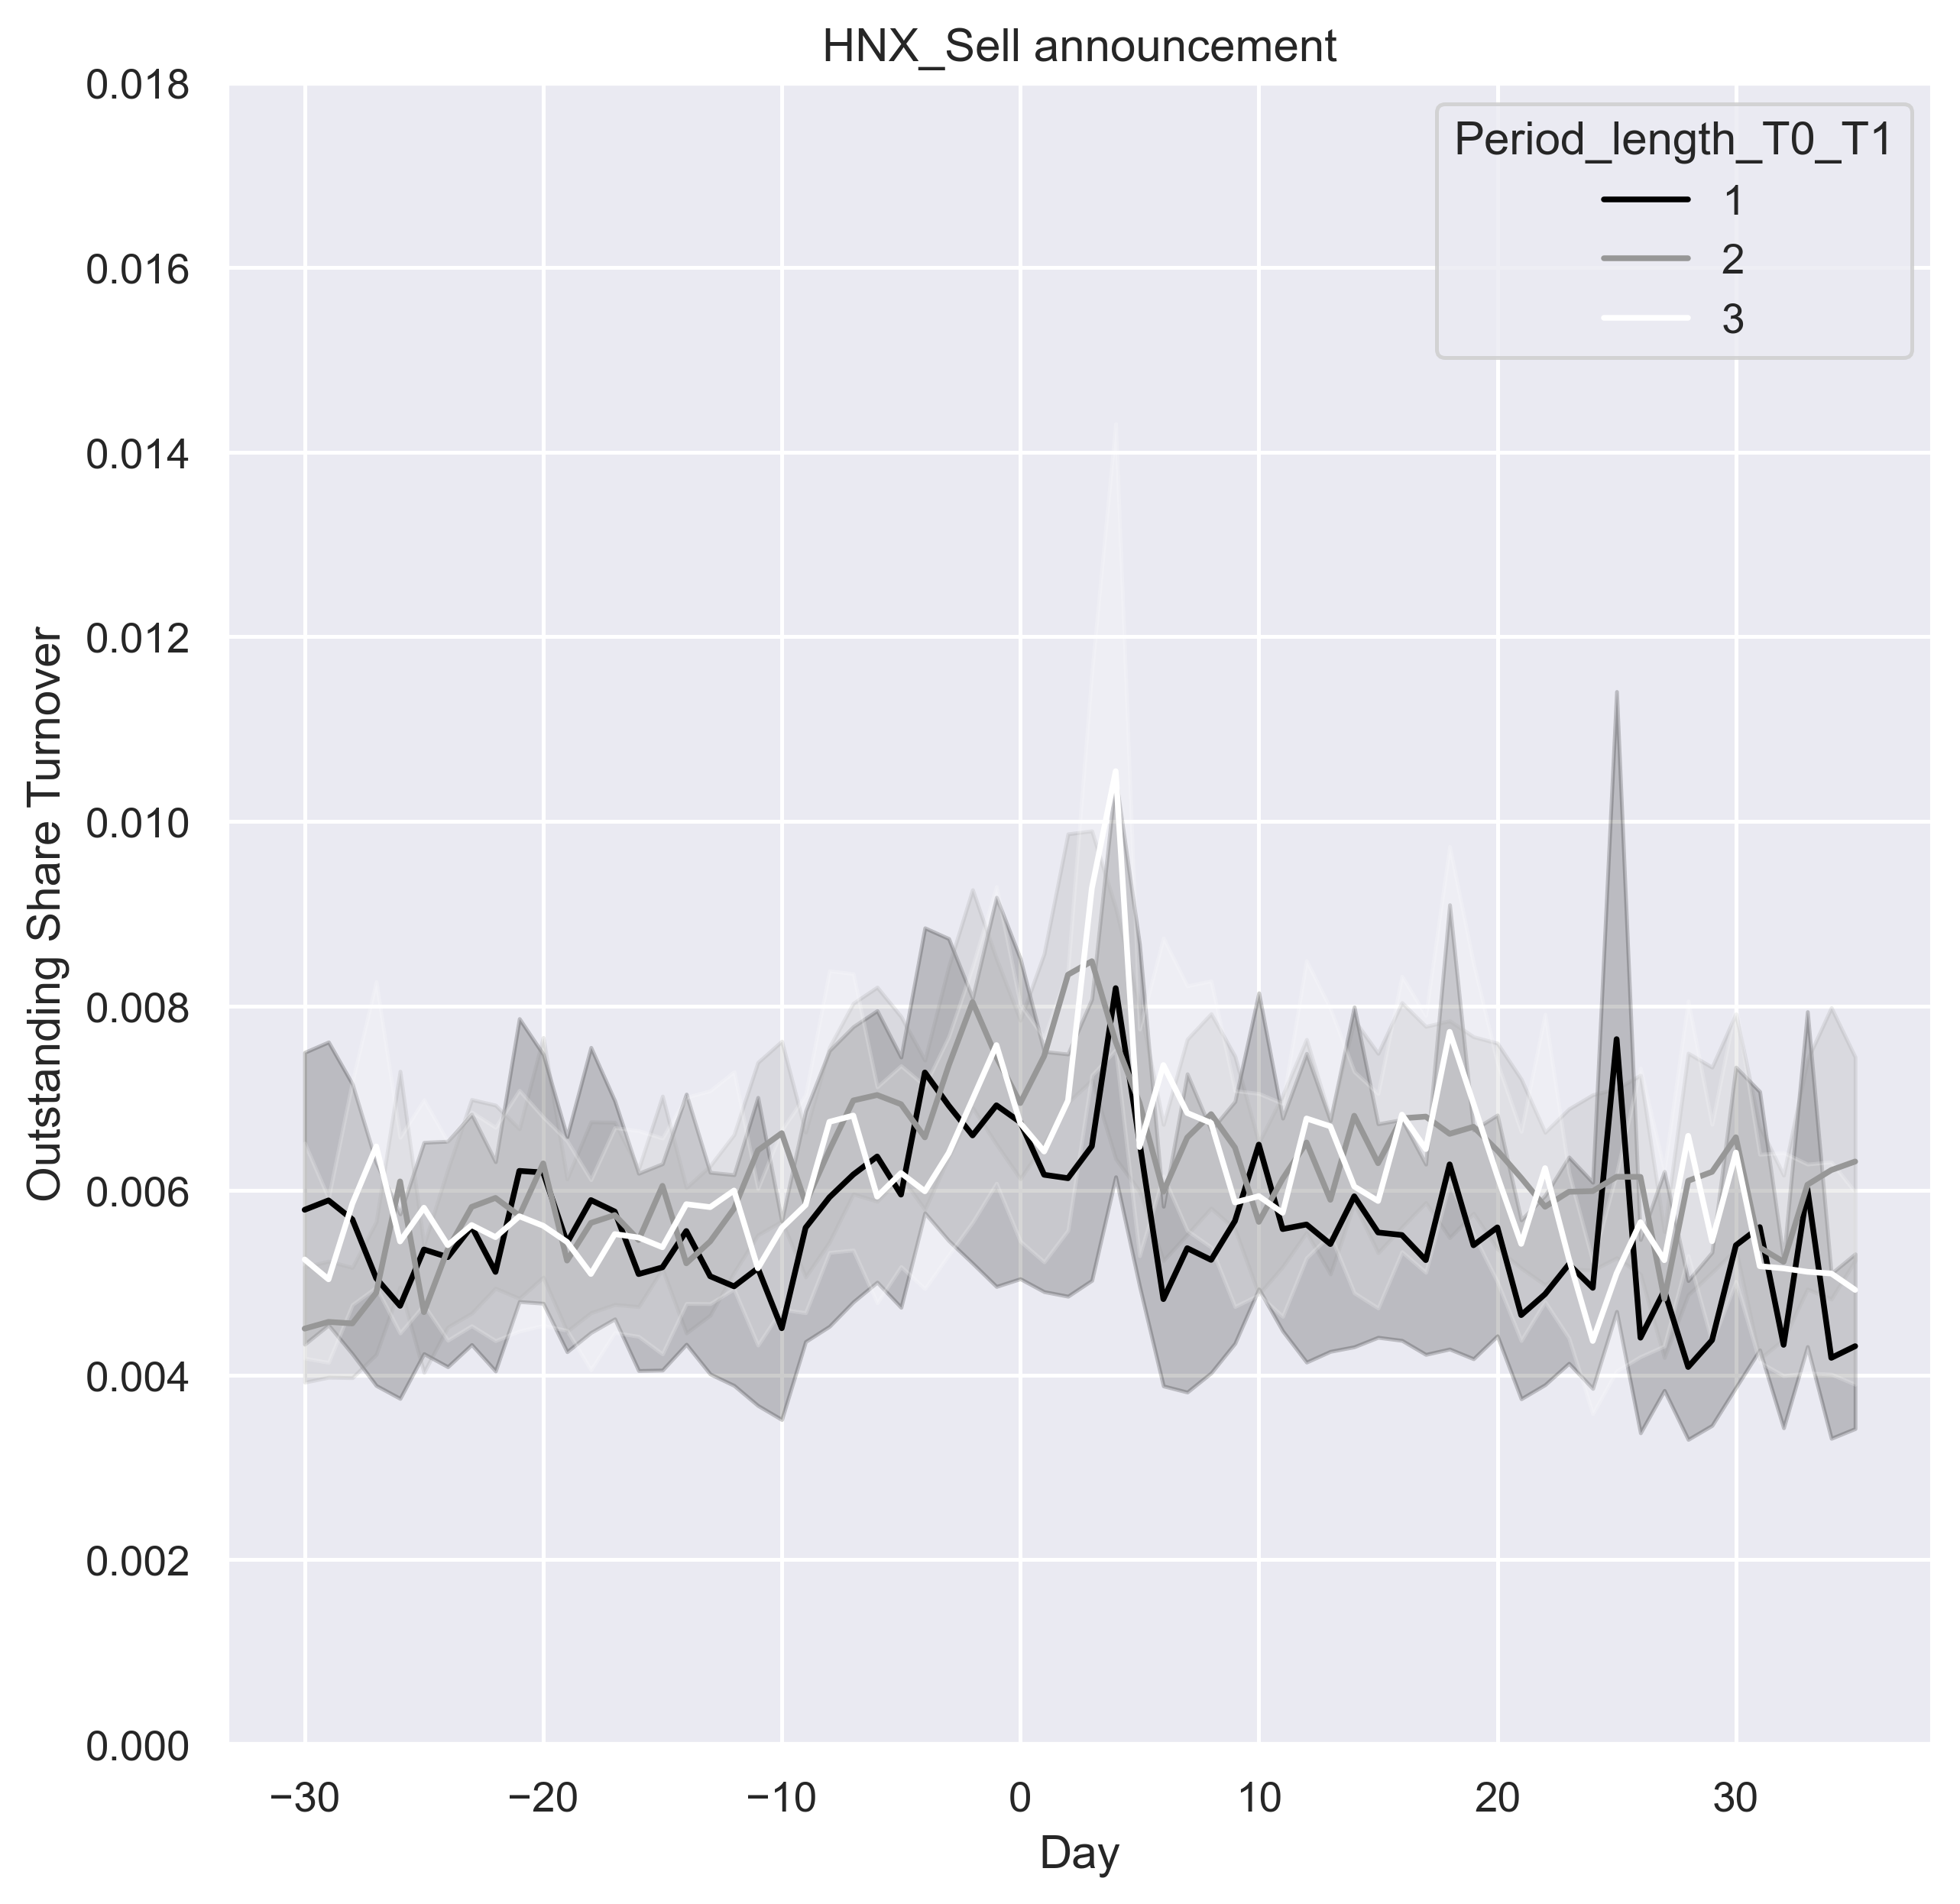

In [34]:
df_sell_vol_HNX = df_HNX_sell.iloc[:,608:674].copy()
df_sell_tos_HNX = df_HNX_sell.iloc[:,674:740].copy()
df_sell_turnover_HNX = df_sell_vol_HNX.div(df_sell_tos_HNX.values)
df_sell_turnover_HNX['Period_length_T0_T1'] = df_HNX_sell['Diff_days_T0_T1'].values
df_sell_turnover_HNX.columns = [i for i in range(-30,37)]
df_sell_turnover_HNX.rename({36: 'Period_length_T0_T1'}, axis=1, inplace=True)

df_sell_turnover_HNX_new = df_sell_turnover_HNX[(df_sell_turnover_HNX['Period_length_T0_T1']<=3)]
df_sell_turnover_HNX_corrected = pd.DataFrame(df_sell_turnover_HNX_new.set_index('Period_length_T0_T1').stack())
df_sell_turnover_HNX_corrected.index.set_names('Day', level=len(df_sell_turnover_HNX_corrected.index.names)-1, inplace=True)
df_sell_turnover_HNX_corrected.columns = ['Outstanding Share Turnover']

OST_sell = sns.lineplot(data=df_sell_turnover_HNX_corrected, x="Day", y="Outstanding Share Turnover",hue="Period_length_T0_T1",ci=90,palette="Greys_r")
OST_sell.set(title='HNX_Sell announcement')
OST_sell.set(ylim=(0, 0.018))

plt.savefig("OST_sell_HNX.png")
#OST_sell.figure.savefig("OST_sell_HNX.png")